In [1]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "./jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding "  # this disables constant folding
#     # "--xla_cpu_use_thunk_runtime=false "
# )
from desc import set_device
set_device("gpu")

In [3]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_explain_cache_misses", True)

In [4]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [5]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [6]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *
from desc.io import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *
from desc.particles import *
from diffrax import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.16.0+47.g50bd906d1.
Using JAX backend: jax version=0.7.2, jaxlib version=0.7.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 10.94 GB available memory.


In [38]:
L = 8
M = 8
N = 8
eq_island = load(
    f"./Poincare/ISLAND_STUFF/LANDREMAN2021/eq-org/eq-org-landreman2021-island-L{L}M{M}N{N}.h5"
)
eq_island2 = load(
    f"./Poincare/ISLAND_STUFF/GIULIANI2023/eq-org/eq-org-giuliani2023-island-L{L}M{M}N{N}.h5"
)
eq_QA = get("precise_QA")

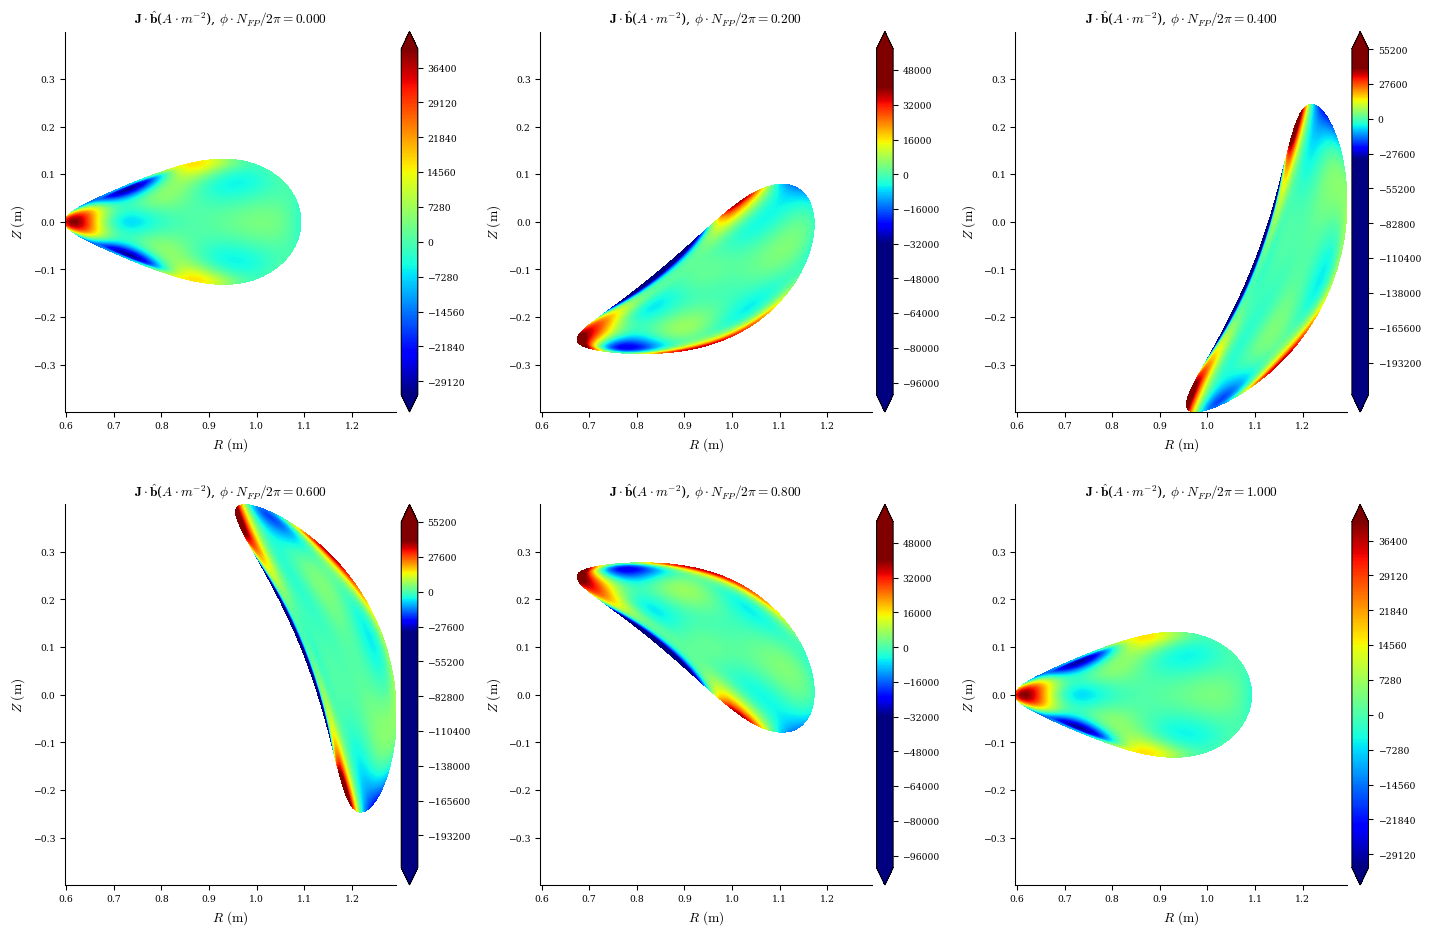

In [39]:
grid = LinearGrid(L=30, M=30, zeta=6, NFP=eq_island.NFP, sym=False, endpoint=True)
levels = 1000
plot_section(eq_island, "J_parallel", grid=grid, levels=levels);
plt.savefig("J_parallel_island.png", dpi=1000)

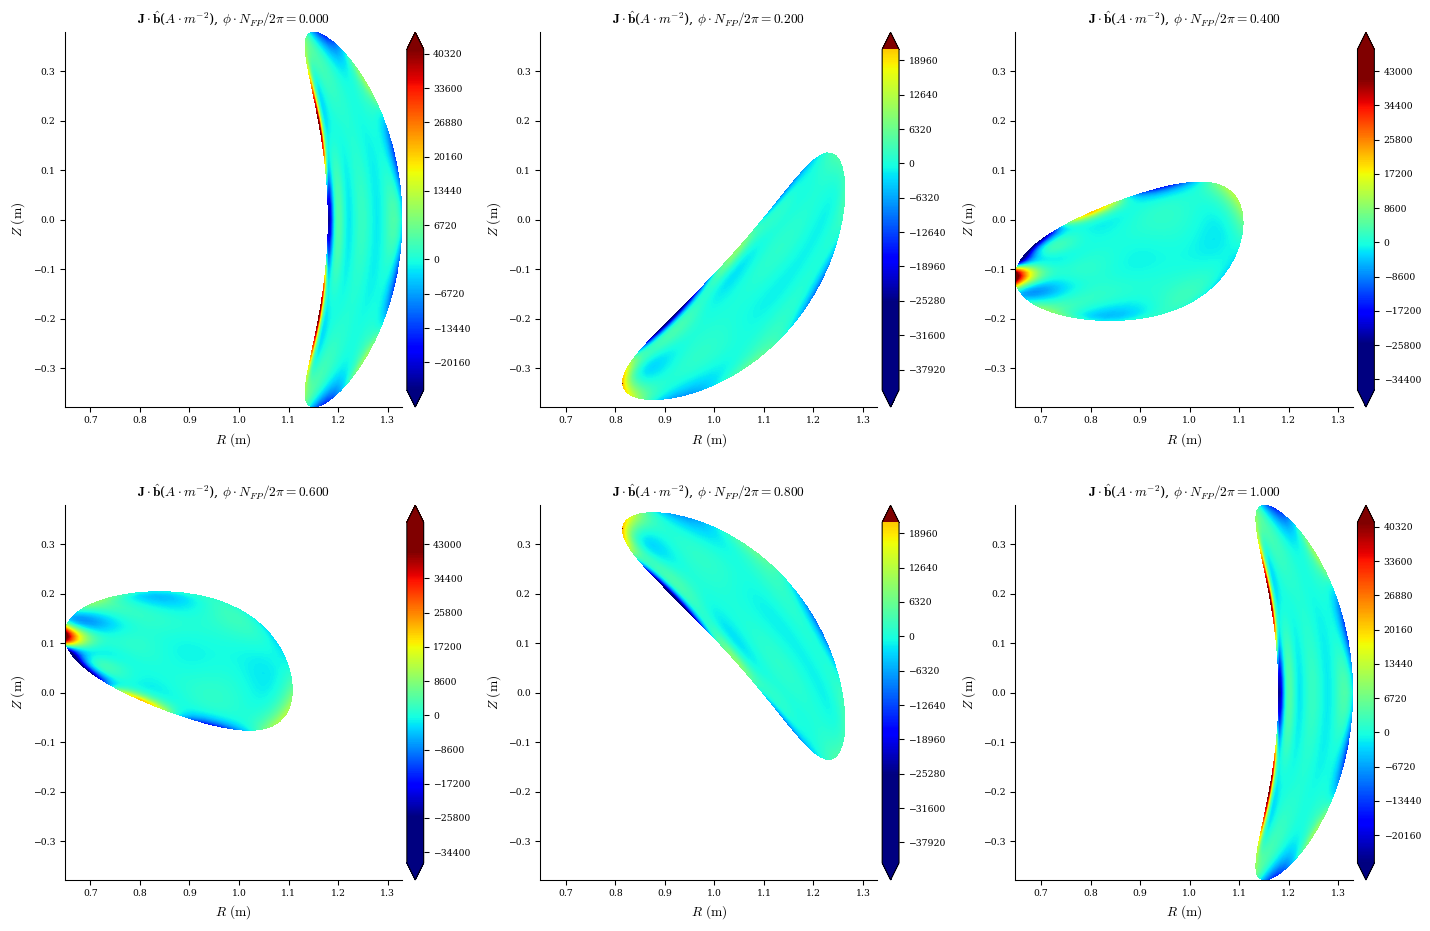

In [40]:
levels = 1000
plot_section(eq_QA, "J_parallel", grid=grid, levels=levels)
plt.savefig("J_parallel_no_island.png", dpi=1000)

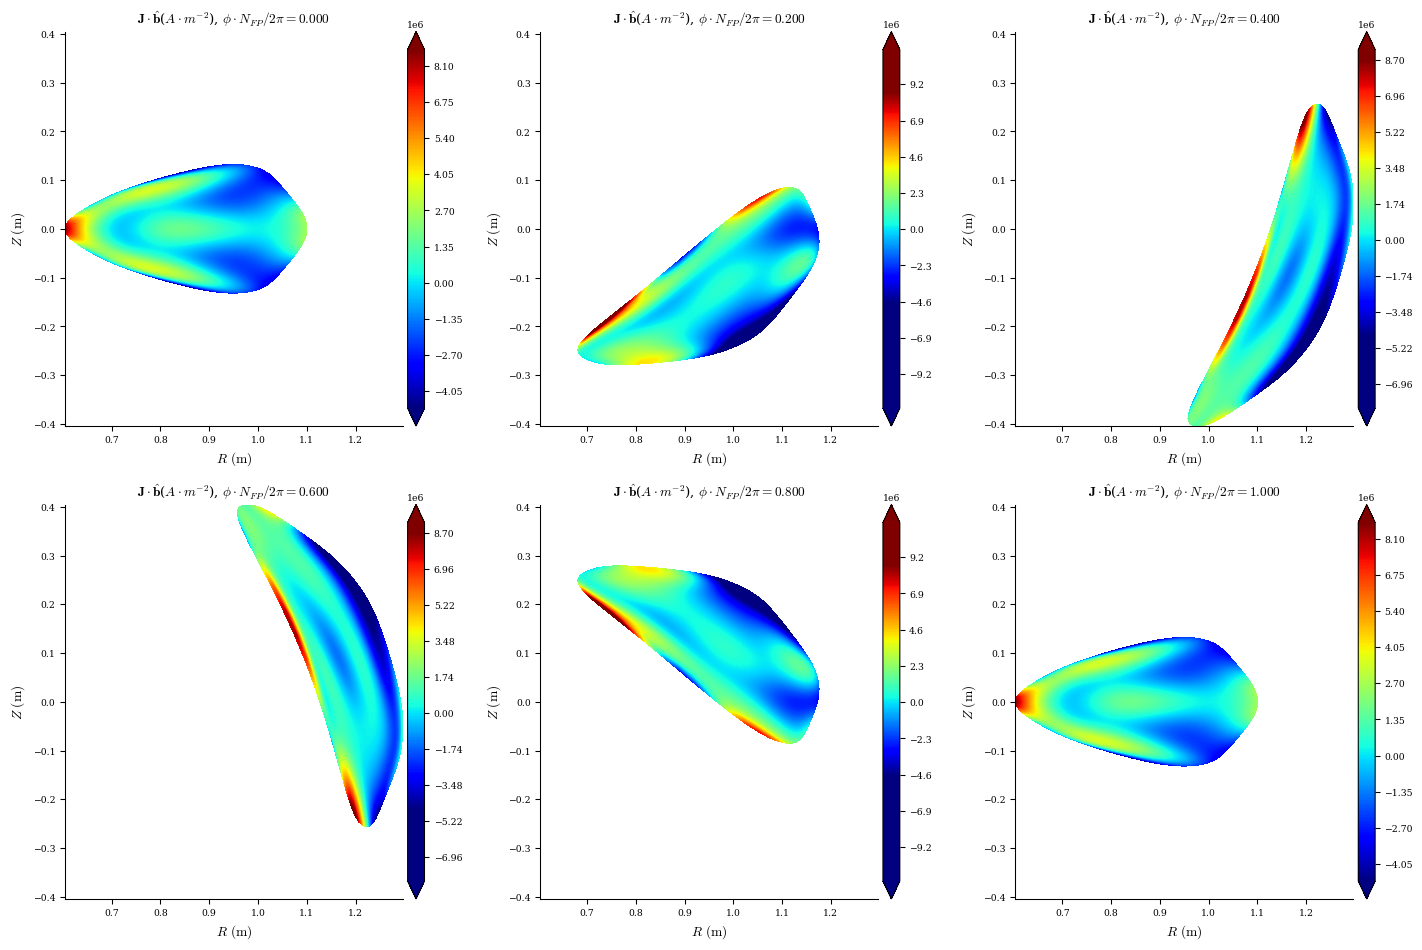

In [41]:
levels = 1000
plot_section(eq_island2, "J_parallel", grid=grid, levels=levels)
plt.savefig("J_parallel_island_guiliani2023.png", dpi=1000)

(<Figure size 384.108x384.108 with 1 Axes>,
 <Axes: xlabel='$\\rho$', ylabel='$ \\iota ~(~)$'>)

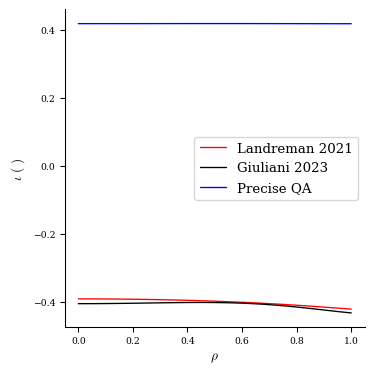

In [46]:
fig, ax = plot_1d(eq_island, "iota", label="Landreman 2021", color="red")
fig, ax = plot_1d(eq_island2, "iota", ax=ax, label="Giuliani 2023", color="black")
plot_1d(eq_QA, "iota", ax=ax, label="Precise QA", color="blue")

In [49]:
eq_island.Psi, eq_island2.Psi, eq_QA.Psi

(np.float64(0.08385727554), np.float64(1.0), np.float64(0.087))

In [54]:
plot_3d(eq_island, "|B|")

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.



In [52]:
plot_3d(eq_island2, "|B|")

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.



In [53]:
plot_3d(eq_QA, "|B|")

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.



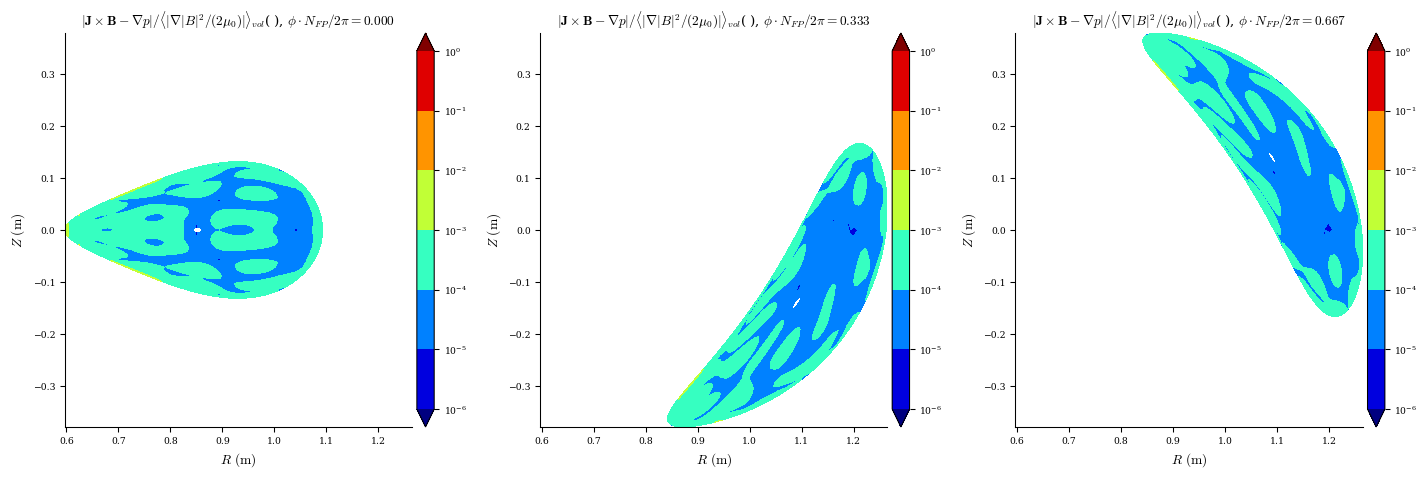

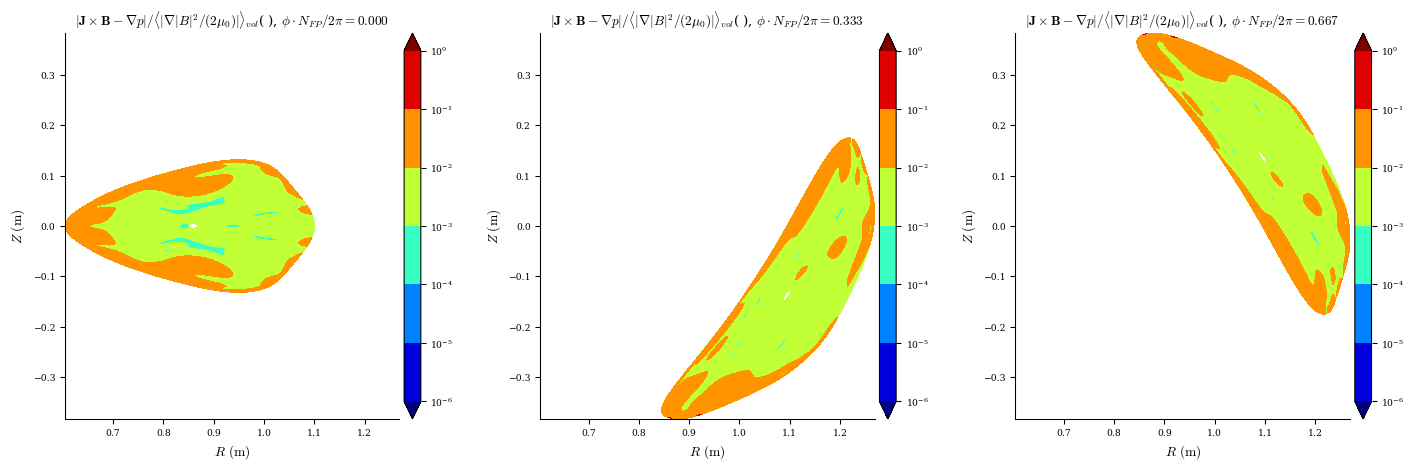

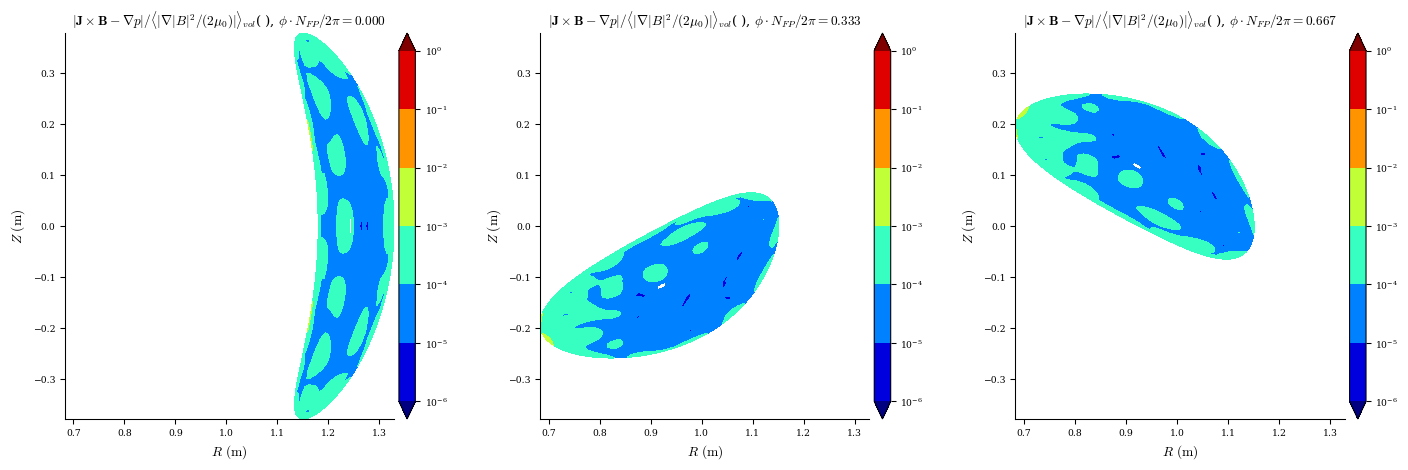

In [57]:
plot_section(eq_island, "|F|_normalized", phi=3, log=True)
plot_section(eq_island2, "|F|_normalized", phi=3, log=True)
plot_section(eq_QA, "|F|_normalized", phi=3, log=True);

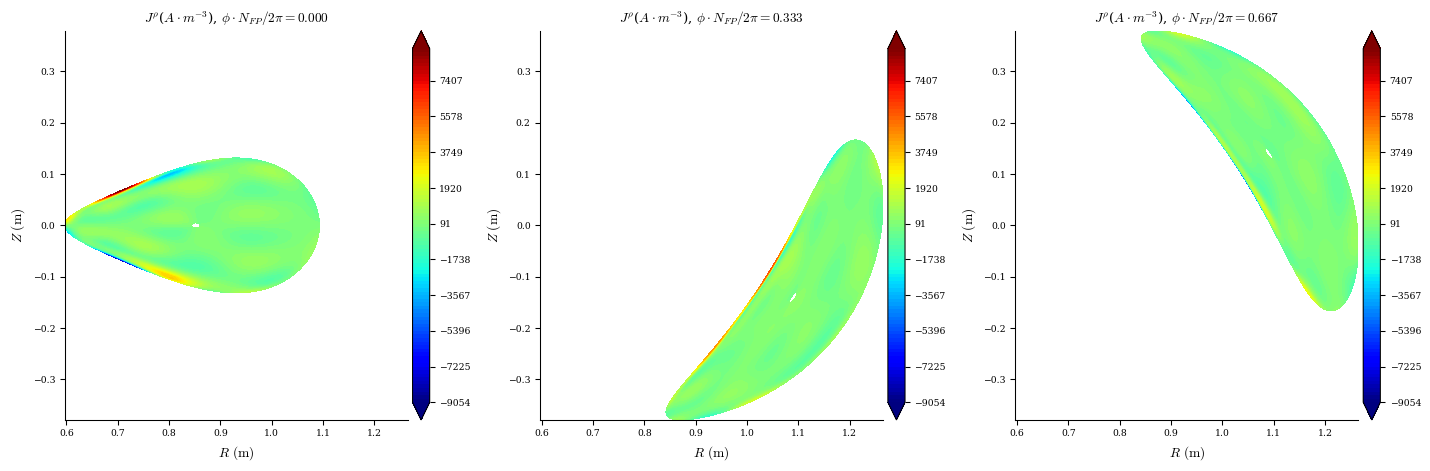

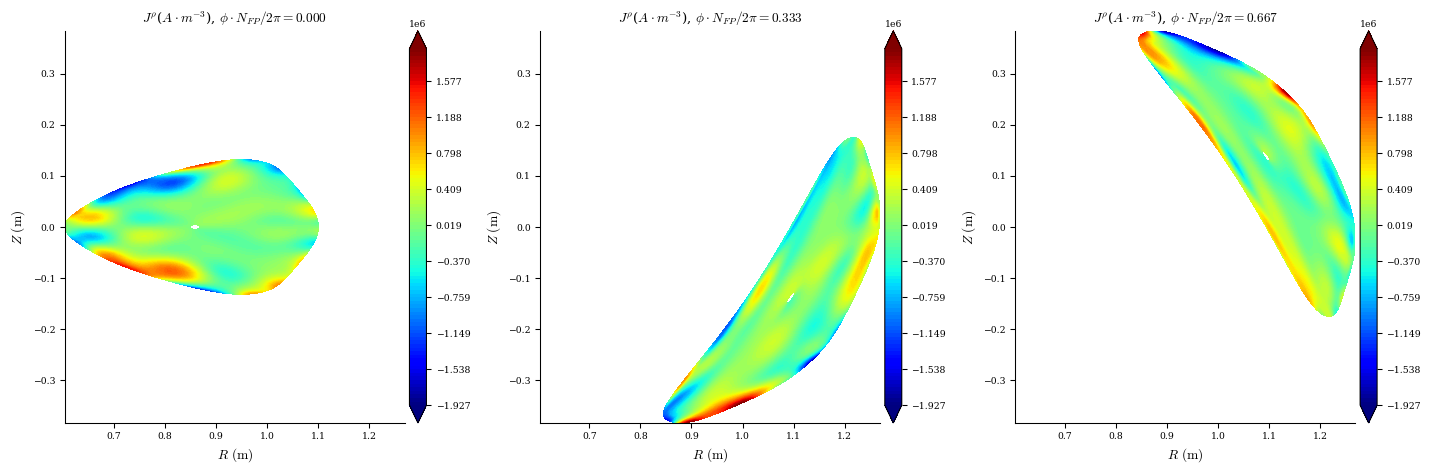

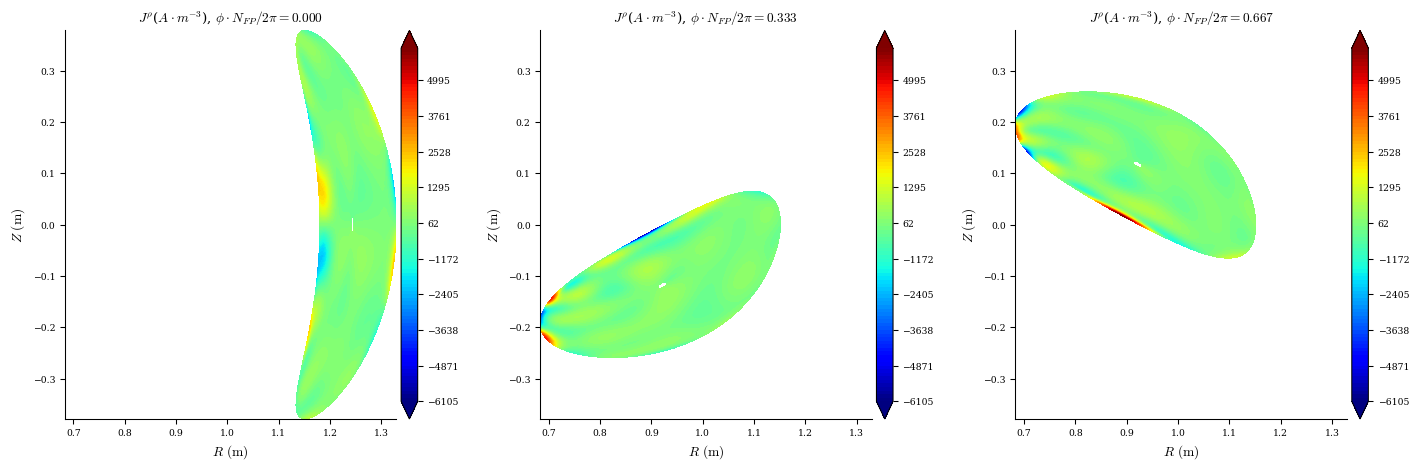

In [59]:
plot_section(eq_island, "J^rho", phi=3)
plot_section(eq_island2, "J^rho", phi=3)
plot_section(eq_QA, "J^rho", phi=3);

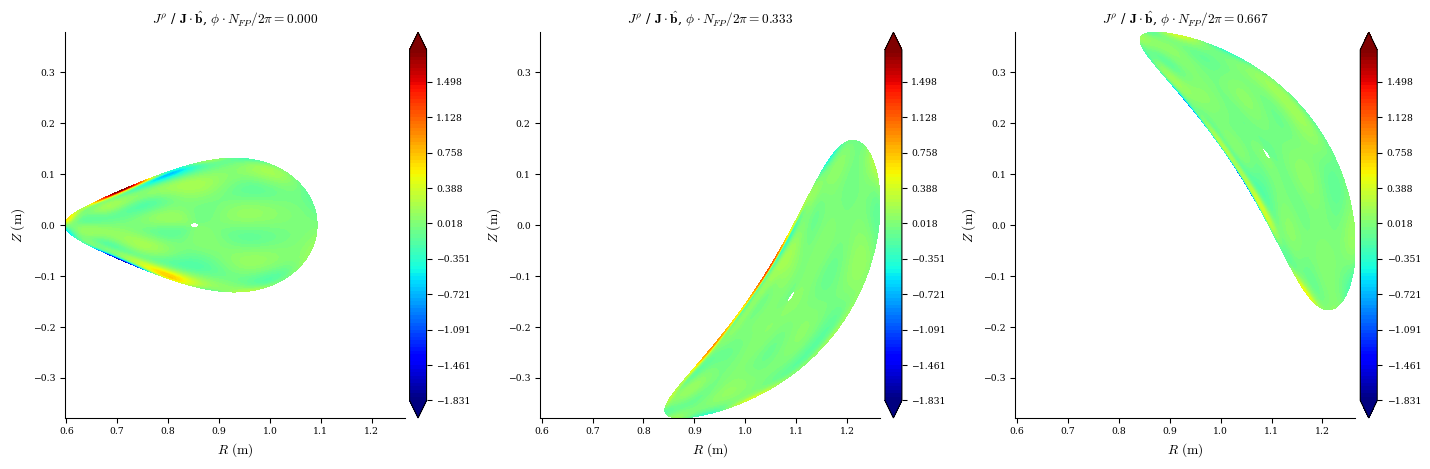

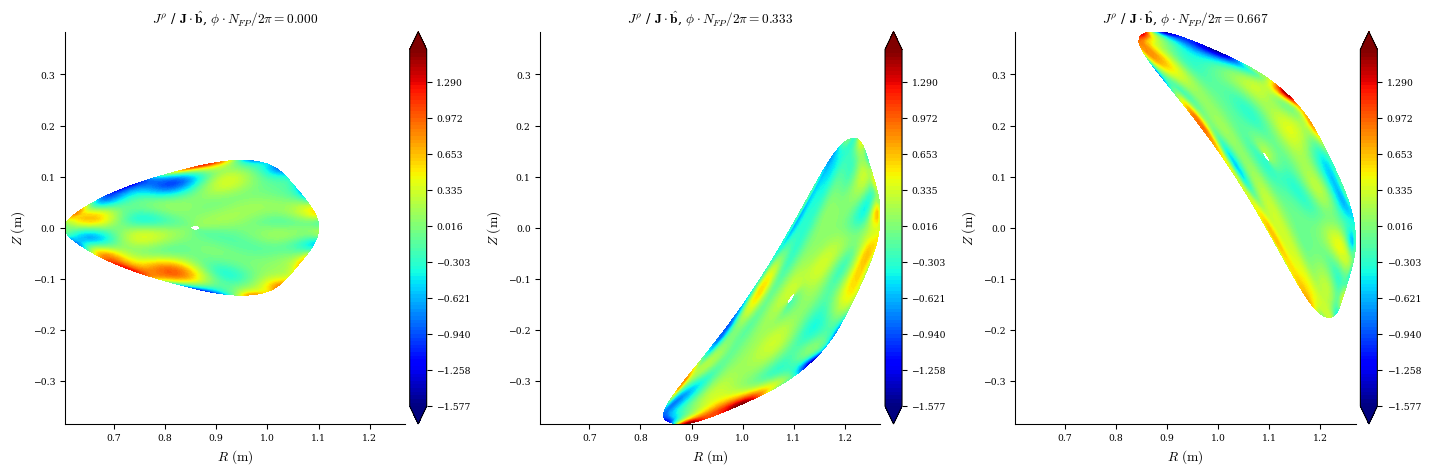

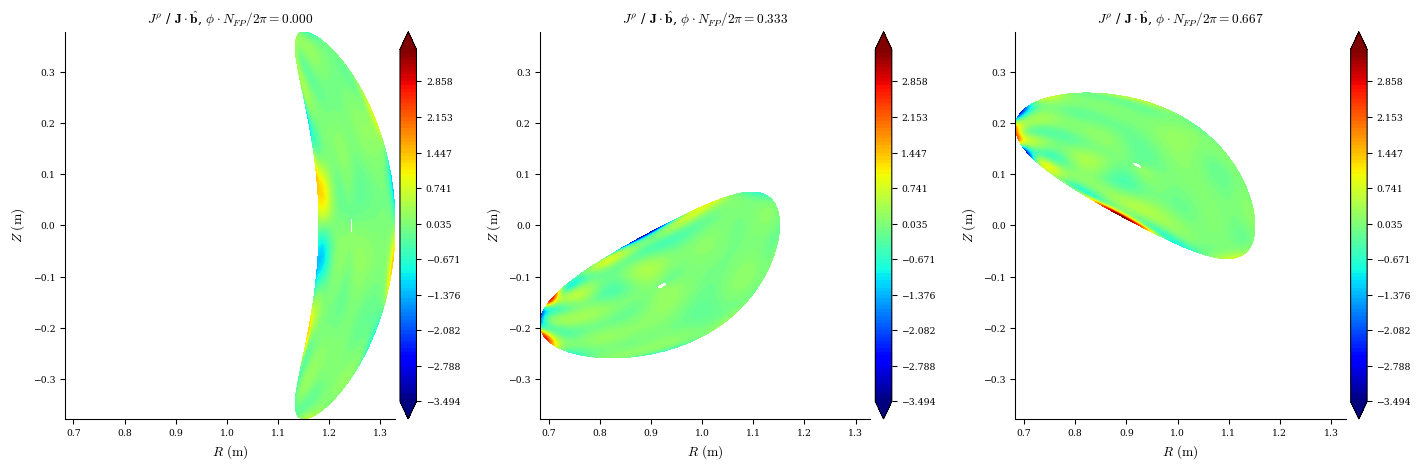

In [60]:
plot_section(eq_island, "J^rho", phi=3, normalize="J_parallel")
plot_section(eq_island2, "J^rho", phi=3, normalize="J_parallel")
plot_section(eq_QA, "J^rho", phi=3, normalize="J_parallel");

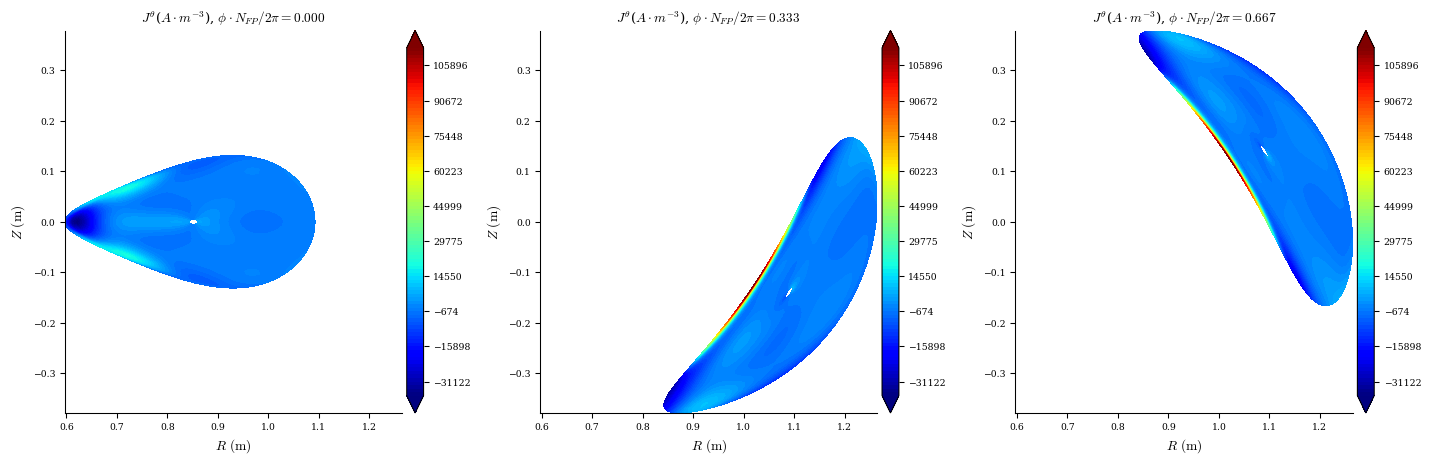

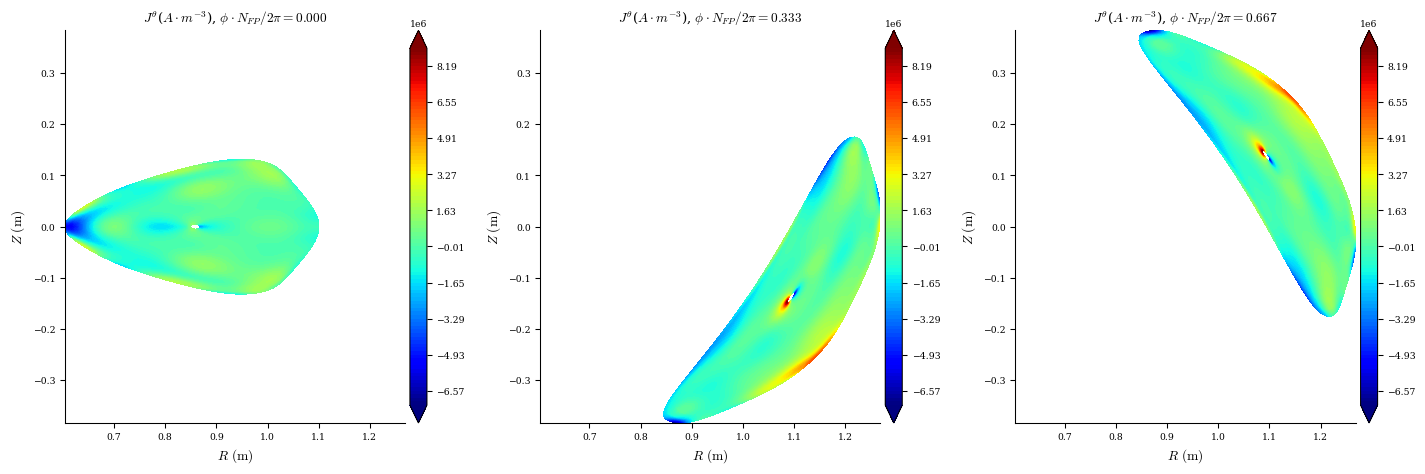

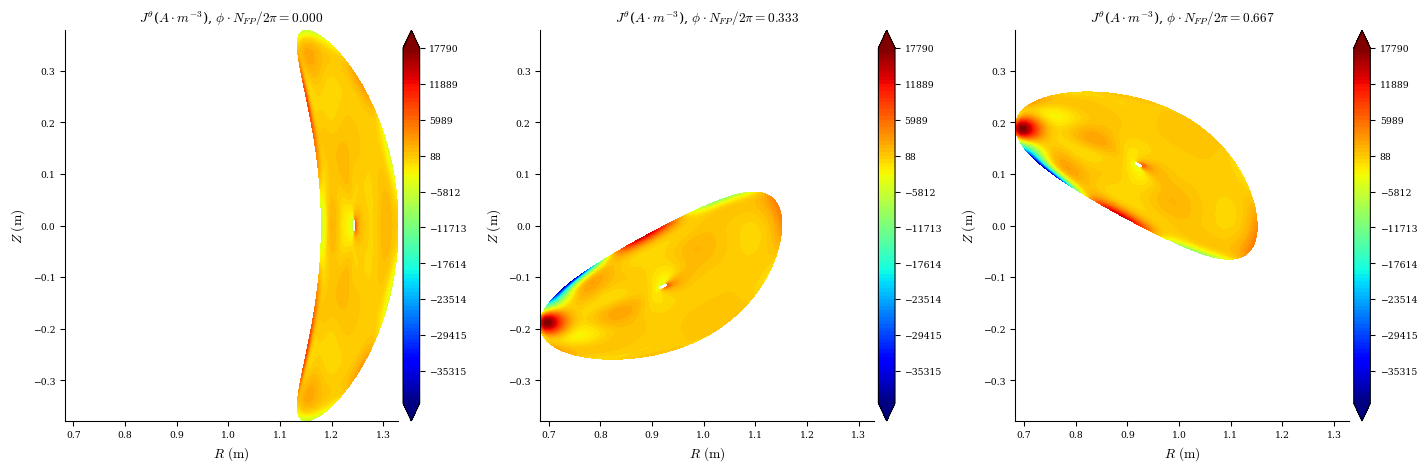

In [61]:
plot_section(eq_island, "J^theta", phi=3)
plot_section(eq_island2, "J^theta", phi=3)
plot_section(eq_QA, "J^theta", phi=3);

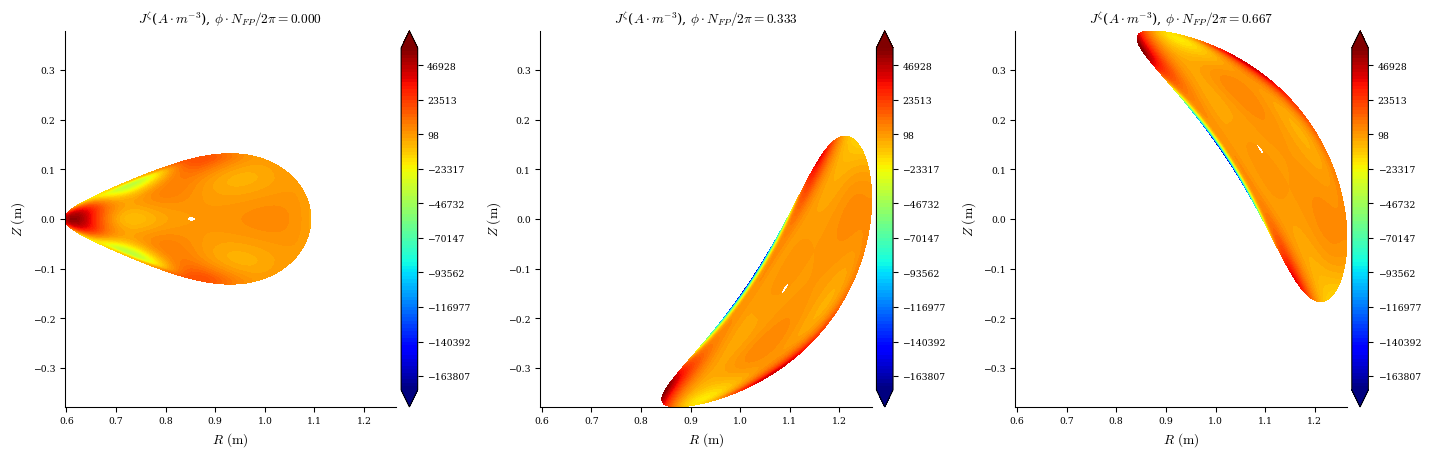

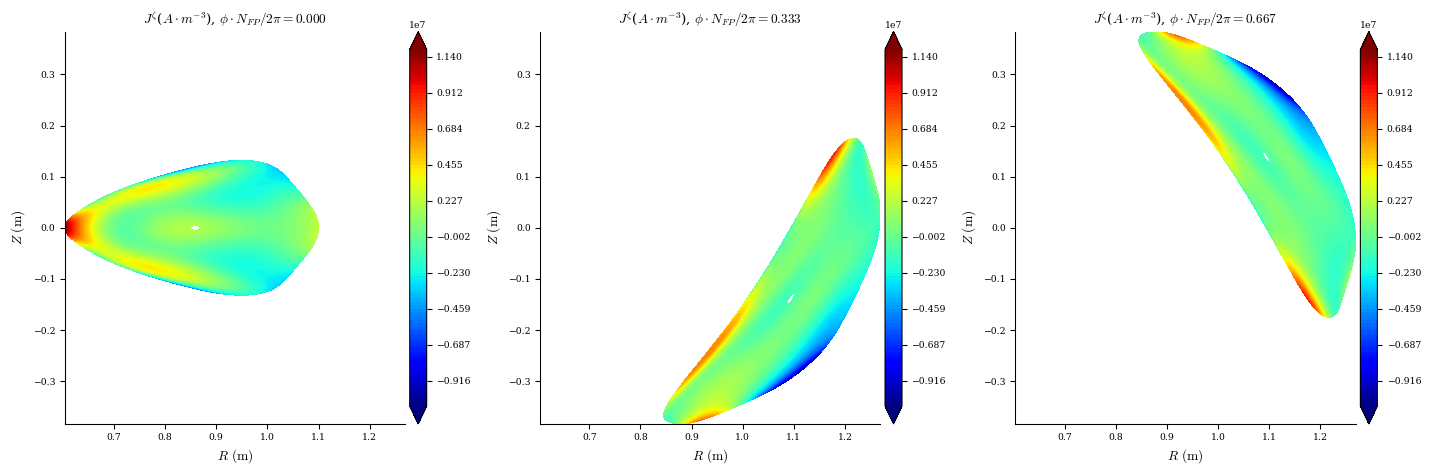

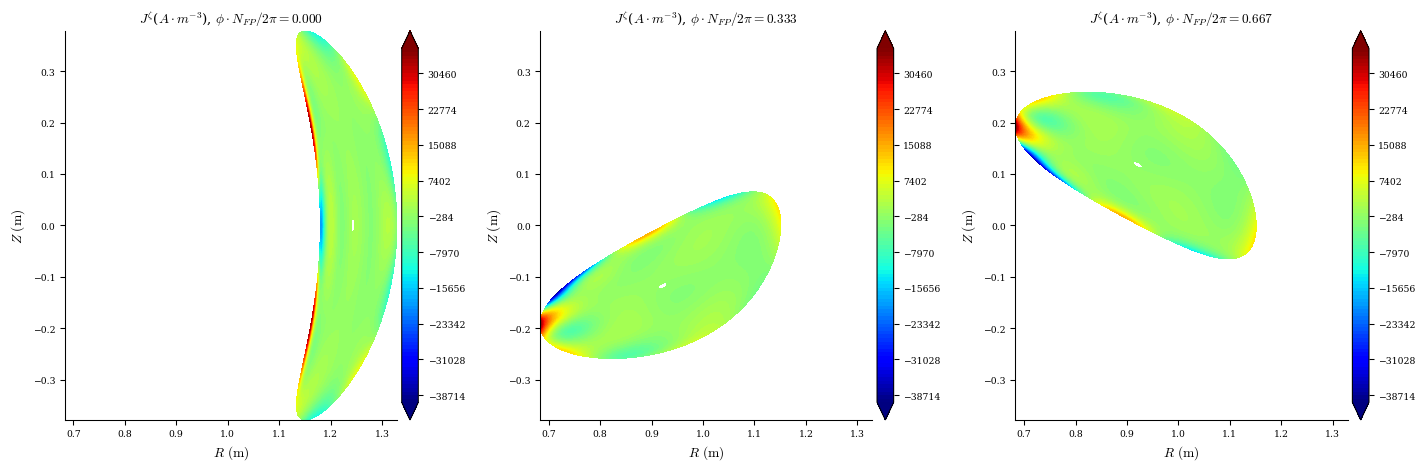

In [62]:
plot_section(eq_island, "J^zeta", phi=3)
plot_section(eq_island2, "J^zeta", phi=3)
plot_section(eq_QA, "J^zeta", phi=3);